In [1]:
#import modules
import pandas as pd
import nltk
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
from tensorflow import keras
import os
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM, Dropout, Dense, Activation
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
#import datasets
historical_data = pd.read_csv("./Datasets/Historical/HistoricalData_APPLE.csv", parse_dates=["Date"], index_col="Date")
headlines_data = pd.read_csv("./Datasets/Headlines/News_headlines.csv", parse_dates=["Date"], index_col="Date")

In [3]:
historical_data.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2021-06-09,$127.13,56877940,$127.21,$127.75,$126.52
2021-06-08,$126.74,74403770,$126.6,$128.46,$126.2101
2021-06-07,$125.9,71057550,$126.17,$126.32,$124.8321
2021-06-04,$125.89,75169340,$124.07,$126.16,$123.85
2021-06-03,$123.54,76229170,$124.68,$124.85,$123.13


In [4]:
headlines_data.head()

,Headlines
Date,
2015-01-01,What Can We Expect From Apple Inc. In 2015? 1 ...
2015-02-01,What to expect from Apple in 2015 beyond its s...
2015-03-01,Mountie: An inexpensive and innovative way to ...
2015-04-01,"Donald Yacktman on the Sources of Moats, His C..."
2015-05-01,"SIM-free iPhone 6, 6 Plus reportedly debuting ..."


In [5]:
print("(",len(historical_data),",",len(headlines_data),")")

( 2516 , 2365 )


In [6]:
#Edit dataset to remove $ and convert to float
historical_data['Open'] = historical_data['Open'].apply(lambda x: x.replace('$',''))
historical_data['Open'] = historical_data['Open'].astype(float)

historical_data['Close/Last'] = historical_data['Close/Last'].apply(lambda x: x.replace('$',''))
historical_data['Close/Last'] = historical_data['Close/Last'].astype(float)

historical_data['High'] = historical_data['High'].apply(lambda x: x.replace('$',''))
historical_data['High'] = historical_data['High'].astype(float)

historical_data['Low'] = historical_data['Low'].apply(lambda x: x.replace('$',''))
historical_data['Low'] = historical_data['Low'].astype(float)

historical_data = historical_data.sort_index(ascending = True, axis = 0)
historical_data

,Close/Last,Volume,Open,High,Low
Date,,,,,
2011-06-10,11.6393,433801306,11.8054,11.8450,11.6254
2011-06-13,11.6643,329376468,11.6857,11.7254,11.6096
2011-06-14,11.8729,333995906,11.7857,11.9018,11.7611
2011-06-15,11.6696,395841722,11.7768,11.7964,11.6029
2011-06-16,11.6129,507299317,11.6750,11.7386,11.3689
...,...,...,...,...,...
2021-06-03,123.5400,76229170,124.6800,124.8500,123.1300
2021-06-04,125.8900,75169340,124.0700,126.1600,123.8500
2021-06-07,125.9000,71057550,126.1700,126.3200,124.8321


In [7]:
historical_data.sort_values('Date', inplace=True)

In [8]:
historical_data.reset_index()

,Date,Close/Last,Volume,Open,High,Low
0,2011-06-10,11.6393,433801306,11.8054,11.8450,11.6254
1,2011-06-13,11.6643,329376468,11.6857,11.7254,11.6096
2,2011-06-14,11.8729,333995906,11.7857,11.9018,11.7611
3,2011-06-15,11.6696,395841722,11.7768,11.7964,11.6029
4,2011-06-16,11.6129,507299317,11.6750,11.7386,11.3689
...,...,...,...,...,...,...
2511,2021-06-03,123.5400,76229170,124.6800,124.8500,123.1300
2512,2021-06-04,125.8900,75169340,124.0700,126.1600,123.8500
2513,2021-06-07,125.9000,71057550,126.1700,126.3200,124.8321
2514,2021-06-08,126.7400,74403770,126.6000,128.4600,126.2101


In [9]:
headlines_data

,Headlines
Date,
2015-01-01,What Can We Expect From Apple Inc. In 2015? 1 ...
2015-02-01,What to expect from Apple in 2015 beyond its s...
2015-03-01,Mountie: An inexpensive and innovative way to ...
2015-04-01,"Donald Yacktman on the Sources of Moats, His C..."
2015-05-01,"SIM-free iPhone 6, 6 Plus reportedly debuting ..."
...,...
2021-06-19,Best pre-Prime Day smartwatch deals on Apple W...
2021-06-20,iPhone 13 rumors: As Apple's fall event gets c...
2021-06-21,Apple is shortening new free TV Plus trials fr...


In [10]:
merged_data = pd.merge(historical_data, headlines_data, how='inner', on=['Date'])
merged_data.dropna(axis = 0, inplace = True)
merged_data

,Close/Last,Volume,Open,High,Low,Headlines
Date,,,,,,
2015-01-02,27.3325,212575080,27.8475,27.8600,26.8375,"Apple Loop: iOS 8.1.3 Angers Users, Outlook Ar..."
2015-01-05,26.5625,256843520,27.0725,27.1625,26.3525,"Apple Watch interest described as &quot;tepid,..."
2015-01-06,26.5650,262729000,26.6350,26.8575,26.1575,Apple&quot;s TV Service Delayed: Getting Local...
2015-01-07,26.9375,159933400,26.8000,27.0500,26.6737,Apple Inc. leaks new iPod colors in iTunes 12....
2015-01-08,27.9725,236675040,27.3075,28.0375,27.1750,Nomura Begins Coverage on Apple (AAPL) IBM cou...
...,...,...,...,...,...,...
2021-05-28,124.6100,71311110,125.5700,125.8000,124.5500,Apple pushes back launch of podcast subscripti...
2021-06-01,124.2800,67637120,125.0800,125.3500,123.9400,"TSX nears record high as cannabis, renewables ..."
2021-06-02,125.0600,59278860,124.2800,125.2400,124.0500,Exclusive Social Media App Clubhouse Rises In ...


In [11]:
merged_data.sort_values('Date', inplace=True)
merged_data

,Close/Last,Volume,Open,High,Low,Headlines
Date,,,,,,
2015-01-02,27.3325,212575080,27.8475,27.8600,26.8375,"Apple Loop: iOS 8.1.3 Angers Users, Outlook Ar..."
2015-01-05,26.5625,256843520,27.0725,27.1625,26.3525,"Apple Watch interest described as &quot;tepid,..."
2015-01-06,26.5650,262729000,26.6350,26.8575,26.1575,Apple&quot;s TV Service Delayed: Getting Local...
2015-01-07,26.9375,159933400,26.8000,27.0500,26.6737,Apple Inc. leaks new iPod colors in iTunes 12....
2015-01-08,27.9725,236675040,27.3075,28.0375,27.1750,Nomura Begins Coverage on Apple (AAPL) IBM cou...
...,...,...,...,...,...,...
2021-05-28,124.6100,71311110,125.5700,125.8000,124.5500,Apple pushes back launch of podcast subscripti...
2021-06-01,124.2800,67637120,125.0800,125.3500,123.9400,"TSX nears record high as cannabis, renewables ..."
2021-06-02,125.0600,59278860,124.2800,125.2400,124.0500,Exclusive Social Media App Clubhouse Rises In ...


In [12]:
merged_data["compound"] = ' '
merged_data["negative"] = ' '
merged_data["neutral"] = ' '
merged_data["positive"] = ' '
merged_data.head()

,Close/Last,Volume,Open,High,Low,Headlines,compound,negative,neutral,positive
Date,,,,,,,,,,
2015-01-02,27.3325,212575080,27.8475,27.8600,26.8375,"Apple Loop: iOS 8.1.3 Angers Users, Outlook Ar...",,,,
2015-01-05,26.5625,256843520,27.0725,27.1625,26.3525,"Apple Watch interest described as &quot;tepid,...",,,,
2015-01-06,26.5650,262729000,26.6350,26.8575,26.1575,Apple&quot;s TV Service Delayed: Getting Local...,,,,
2015-01-07,26.9375,159933400,26.8000,27.0500,26.6737,Apple Inc. leaks new iPod colors in iTunes 12....,,,,
2015-01-08,27.9725,236675040,27.3075,28.0375,27.1750,Nomura Begins Coverage on Apple (AAPL) IBM cou...,,,,


In [13]:
sid = SentimentIntensityAnalyzer()
merged_data["compound"] = merged_data["Headlines"].apply(lambda x : sid.polarity_scores(x)['compound'])
merged_data["negative"] = merged_data["Headlines"].apply(lambda x : sid.polarity_scores(x)['neg'])
merged_data["neutral"] = merged_data["Headlines"].apply(lambda x : sid.polarity_scores(x)['neu'])
merged_data["positive"] = merged_data["Headlines"].apply(lambda x : sid.polarity_scores(x)['pos'])
merged_data.head()

,Close/Last,Volume,Open,High,Low,Headlines,compound,negative,neutral,positive
Date,,,,,,,,,,
2015-01-02,27.3325,212575080,27.8475,27.8600,26.8375,"Apple Loop: iOS 8.1.3 Angers Users, Outlook Ar...",0.1943,0.116,0.749,0.135
2015-01-05,26.5625,256843520,27.0725,27.1625,26.3525,"Apple Watch interest described as &quot;tepid,...",0.9770,0.051,0.849,0.100
2015-01-06,26.5650,262729000,26.6350,26.8575,26.1575,Apple&quot;s TV Service Delayed: Getting Local...,0.9932,0.034,0.862,0.105
2015-01-07,26.9375,159933400,26.8000,27.0500,26.6737,Apple Inc. leaks new iPod colors in iTunes 12....,0.9866,0.059,0.812,0.129
2015-01-08,27.9725,236675040,27.3075,28.0375,27.1750,Nomura Begins Coverage on Apple (AAPL) IBM cou...,0.7430,0.037,0.843,0.120


In [14]:
merged_data.drop(["Headlines"], inplace = True, axis = 1)
merged_data = merged_data[["Close/Last", "compound", "negative", "neutral", "positive", "Open", "High", "Low", "Volume"]]
merged_data.head()

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2015-01-02,27.3325,0.1943,0.116,0.749,0.135,27.8475,27.8600,26.8375,212575080
2015-01-05,26.5625,0.9770,0.051,0.849,0.100,27.0725,27.1625,26.3525,256843520
2015-01-06,26.5650,0.9932,0.034,0.862,0.105,26.6350,26.8575,26.1575,262729000
2015-01-07,26.9375,0.9866,0.059,0.812,0.129,26.8000,27.0500,26.6737,159933400
2015-01-08,27.9725,0.7430,0.037,0.843,0.120,27.3075,28.0375,27.1750,236675040


In [15]:
#merged_data.to_csv("Stock_Data_with_vader.csv")

In [16]:
stock_data = pd.read_csv("./Datasets/Stock_Data_with_vader.csv", index_col = False)
stock_data.set_index("Date", inplace = True)
stock_data.head()

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2015-01-02,27.3325,0.1943,0.116,0.749,0.135,27.8475,27.8600,26.8375,212575080
2015-01-05,26.5625,0.9770,0.051,0.849,0.100,27.0725,27.1625,26.3525,256843520
2015-01-06,26.5650,0.9932,0.034,0.862,0.105,26.6350,26.8575,26.1575,262729000
2015-01-07,26.9375,0.9866,0.059,0.812,0.129,26.8000,27.0500,26.6737,159933400
2015-01-08,27.9725,0.7430,0.037,0.843,0.120,27.3075,28.0375,27.1750,236675040


In [17]:
stock_data.shape

(1595, 9)

In [18]:
stock_data.isna().sum()

Close/Last    0
compound      0
negative      0
neutral       0
positive      0
Open          0
High          0
Low           0
Volume        0
dtype: int64

In [19]:
stock_data.describe(include = 'all')

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
count,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1595.000000,1.595000e+03
mean,52.393220,0.682981,0.057650,0.837519,0.104848,52.376195,52.936966,51.814284,1.430715e+08
std,30.376239,0.617343,0.030753,0.040650,0.033087,30.410005,30.820348,29.928991,7.032894e+07
min,22.585000,-0.999600,0.000000,0.666000,0.000000,22.500000,22.917500,22.367500,4.544820e+07
25%,30.331250,0.838300,0.037000,0.814000,0.083000,30.282500,30.562500,30.112500,9.483556e+07
50%,42.605000,0.979500,0.053000,0.841000,0.103000,42.622500,42.967500,42.312500,1.255845e+08
75%,56.761250,0.994650,0.072000,0.864000,0.125000,56.900000,57.256250,56.435000,1.698299e+08
max,143.160000,0.999600,0.241000,1.000000,0.256000,143.600000,145.090000,141.370000,6.475300e+08


In [20]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1595 entries, 2015-01-02 to 2021-06-04
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close/Last  1595 non-null   float64
 1   compound    1595 non-null   float64
 2   negative    1595 non-null   float64
 3   neutral     1595 non-null   float64
 4   positive    1595 non-null   float64
 5   Open        1595 non-null   float64
 6   High        1595 non-null   float64
 7   Low         1595 non-null   float64
 8   Volume      1595 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 124.6+ KB


Text(0, 0.5, 'Close Price (in $)')

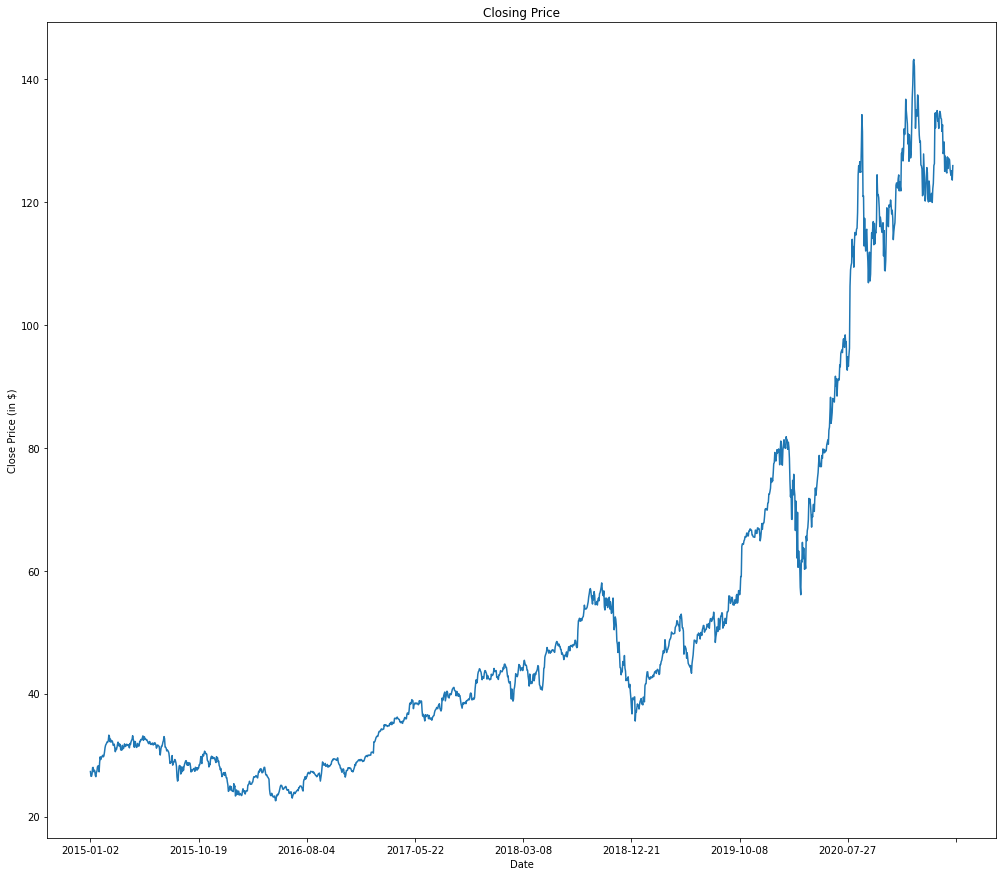

In [21]:
plt.figure(figsize = (17, 15))
stock_data["Close/Last"].plot()
plt.title("Closing Price")
plt.xlabel("Date")
plt.ylabel("Close Price (in $)")

In [22]:
stock_data.rolling(10).mean().head(25)

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='Date'>

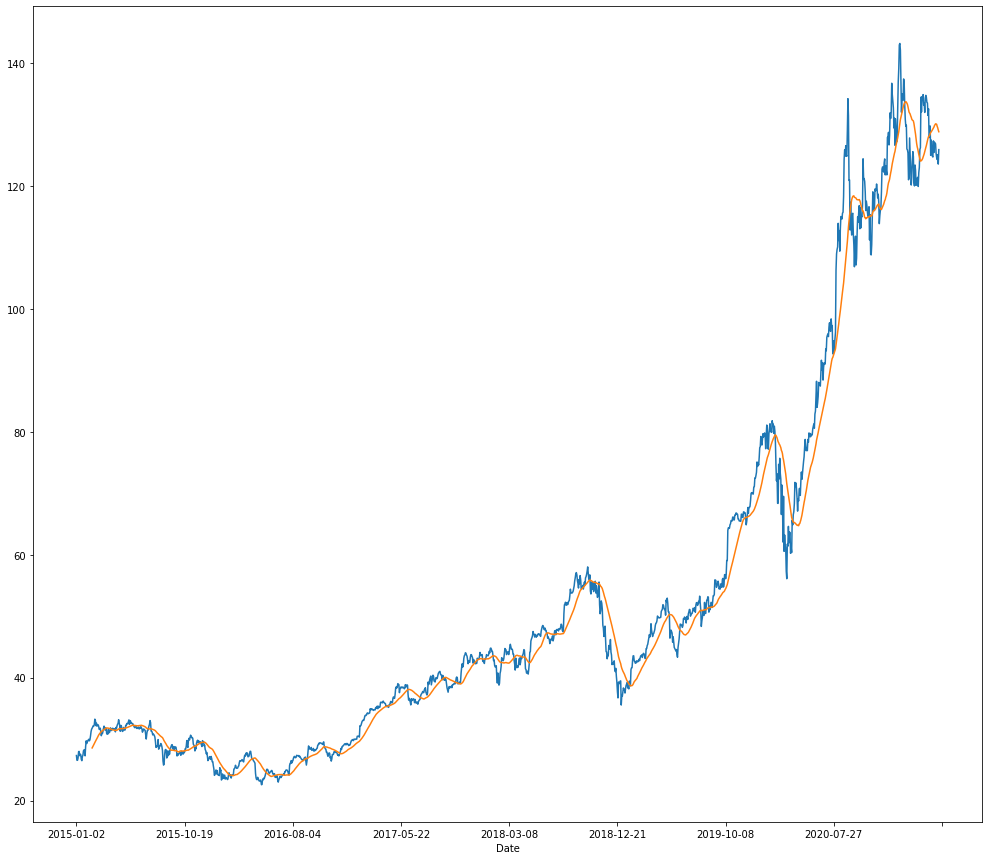

In [23]:
plt.figure(figsize = (17,15))
stock_data["Close/Last"].plot()
stock_data.rolling(window = 30).mean()["Close/Last"].plot()

In [24]:
stock_data

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2015-01-02,27.3325,0.1943,0.116,0.749,0.135,27.8475,27.8600,26.8375,212575080
2015-01-05,26.5625,0.9770,0.051,0.849,0.100,27.0725,27.1625,26.3525,256843520
2015-01-06,26.5650,0.9932,0.034,0.862,0.105,26.6350,26.8575,26.1575,262729000
2015-01-07,26.9375,0.9866,0.059,0.812,0.129,26.8000,27.0500,26.6737,159933400
2015-01-08,27.9725,0.7430,0.037,0.843,0.120,27.3075,28.0375,27.1750,236675040
...,...,...,...,...,...,...,...,...,...
2021-05-28,124.6100,0.9949,0.050,0.842,0.108,125.5700,125.8000,124.5500,71311110
2021-06-01,124.2800,0.9976,0.046,0.836,0.118,125.0800,125.3500,123.9400,67637120
2021-06-02,125.0600,0.7719,0.070,0.835,0.095,124.2800,125.2400,124.0500,59278860


In [25]:
data = int(1.0*(len(stock_data)-1))
split = int(data*0.8)
total_data = len(stock_data)
start = total_data - data
print("Number of records in training data : ", split)
print("Number of records in testing data : ", total_data - split)

Number of records in training data :  1275
Number of records in testing data :  320


In [26]:
close_price = stock_data.iloc[start:total_data, 0]
compound = stock_data.iloc[start:total_data, 1]
negative = stock_data.iloc[start:total_data, 2]
neutral = stock_data.iloc[start:total_data, 3]
positive = stock_data.iloc[start:total_data, 4]
open_price = stock_data.iloc[start:total_data, 5]
high = stock_data.iloc[start:total_data, 6]
low = stock_data.iloc[start:total_data, 7]
volume = stock_data.iloc[start:total_data, 8]

close_price

Date
2015-01-05     26.5625
2015-01-06     26.5650
2015-01-07     26.9375
2015-01-08     27.9725
2015-01-09     28.0025
                ...   
2021-05-28    124.6100
2021-06-01    124.2800
2021-06-02    125.0600
2021-06-03    123.5400
2021-06-04    125.8900
Name: Close/Last, Length: 1594, dtype: float64

In [27]:
shifted_close_price = close_price.shift(-1)
compound_shift = compound.shift(-1)
new_data = pd.concat([close_price, shifted_close_price, compound, compound_shift, volume, open_price, high, low], axis = 1)
new_data.columns = ['close_price', 'shifted_close_price', 'compound', 'compound_shift', 'volume', 'open_price', 'high', 'low']
new_data = new_data.dropna()
new_data.head()

,close_price,shifted_close_price,compound,compound_shift,volume,open_price,high,low
Date,,,,,,,,
2015-01-05,26.5625,26.5650,0.9770,0.9932,256843520,27.0725,27.1625,26.3525
2015-01-06,26.5650,26.9375,0.9932,0.9866,262729000,26.6350,26.8575,26.1575
2015-01-07,26.9375,27.9725,0.9866,0.7430,159933400,26.8000,27.0500,26.6737
2015-01-08,27.9725,28.0025,0.7430,0.9107,236675040,27.3075,28.0375,27.1750
2015-01-09,28.0025,27.3125,0.9107,0.9654,214582920,28.1675,28.3125,27.5525


In [28]:
Y = new_data["shifted_close_price"]
Y

Date
2015-01-05     26.5650
2015-01-06     26.9375
2015-01-07     27.9725
2015-01-08     28.0025
2015-01-09     27.3125
                ...   
2021-05-27    124.6100
2021-05-28    124.2800
2021-06-01    125.0600
2021-06-02    123.5400
2021-06-03    125.8900
Name: shifted_close_price, Length: 1593, dtype: float64

In [29]:
columns = ["close_price", "compound", "compound_shift", "volume", "open_price", "high", "low"]
X = new_data[columns]
X

,close_price,compound,compound_shift,volume,open_price,high,low
Date,,,,,,,
2015-01-05,26.5625,0.9770,0.9932,256843520,27.0725,27.1625,26.3525
2015-01-06,26.5650,0.9932,0.9866,262729000,26.6350,26.8575,26.1575
2015-01-07,26.9375,0.9866,0.7430,159933400,26.8000,27.0500,26.6737
2015-01-08,27.9725,0.7430,0.9107,236675040,27.3075,28.0375,27.1750
2015-01-09,28.0025,0.9107,0.9654,214582920,28.1675,28.3125,27.5525
...,...,...,...,...,...,...,...
2021-05-27,125.2800,0.9986,0.9949,94625600,126.4400,127.6400,125.0800
2021-05-28,124.6100,0.9949,0.9976,71311110,125.5700,125.8000,124.5500
2021-06-01,124.2800,0.9976,0.7719,67637120,125.0800,125.3500,123.9400


In [30]:
from sklearn import preprocessing,metrics
import numpy as np

X_Scale = preprocessing.MinMaxScaler(feature_range = (-1, 1))
X = np.array(X).reshape(len(X), len(columns))
X = X_Scale.fit_transform(X)

Y_Scale = preprocessing.MinMaxScaler(feature_range = (-1, 1))
Y = np.array(Y).reshape(len(Y), 1)
Y = Y_Scale.fit_transform(Y)

X

array([[-0.93402447,  0.97739096,  0.99359744, ..., -0.9244839 ,
        -0.93050809, -0.93302662],
       [-0.933983  ,  0.99359744,  0.9869948 , ..., -0.93170933,
        -0.93550103, -0.93630386],
       [-0.92780427,  0.9869948 ,  0.74329732, ..., -0.92898431,
        -0.93234975, -0.92762841],
       ...,
       [ 0.68683392,  0.9979992 ,  0.77220888, ...,  0.69413708,
         0.67685036,  0.70706498],
       [ 0.69977193,  0.77220888, -0.33493397, ...,  0.68092486,
         0.67504962,  0.70891368],
       [ 0.6745594 , -0.33493397,  0.9814926 , ...,  0.68753097,
         0.66866521,  0.69345182]])

In [31]:
Y

array([[-0.933983  ],
       [-0.92780427],
       [-0.91063653],
       ...,
       [ 0.69977193],
       [ 0.6745594 ],
       [ 0.71353929]])

In [32]:
Y.shape

(1593, 1)

In [33]:
X_train = X[0:split,]
X_test = X[split+1:len(X),]
Y_train = Y[0:split]
Y_test = Y[split+1:len(Y)]

print("Rows and columns in X and Y Training Sets are ", X_train.shape, "and",Y_train.shape, "respectively")
print("Rows and columns in X and Y Testing Sets are ", X_test.shape,"and", Y_test.shape, "respectively")

Rows and columns in X and Y Training Sets are  (1275, 7) and (1275, 1) respectively
Rows and columns in X and Y Testing Sets are  (317, 7) and (317, 1) respectively


In [34]:
X_train  = X_train.reshape(X_train.shape +(1,))
X_test  = X_test.reshape(X_test.shape +(1,))

print("Shape of Traing and Test Set of X are ", X_train.shape, "and", X_test.shape, "respectively")

Shape of Traing and Test Set of X are  (1275, 7, 1) and (317, 7, 1) respectively


In [35]:
np.random.seed(500)
model = keras.Sequential()
model.add(keras.layers.LSTM(200, return_sequences = True, activation = "tanh", input_shape = (len(columns), 1)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.LSTM(250, activation = "tanh"))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 200)            161600    
_________________________________________________________________
dropout (Dropout)            (None, 7, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 250)               451000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 251       
Total params: 612,851
Trainable params: 612,851
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(loss='mse', optimizer='adam')

history = model.fit(X_train,Y_train, epochs = 100, batch_size = 16, validation_split = 0.2, verbose=1)

Epoch 1/100
64/64 [==============================] - 9s 54ms/step - loss: 0.0730 - val_loss: 0.0745
Epoch 2/100
64/64 [==============================] - 2s 32ms/step - loss: 0.0127 - val_loss: 0.0467
Epoch 3/100
64/64 [==============================] - 2s 32ms/step - loss: 0.0085 - val_loss: 0.0240
Epoch 4/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0066 - val_loss: 0.0075
Epoch 5/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0048 - val_loss: 0.0061
Epoch 6/100
64/64 [==============================] - 2s 29ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 7/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 8/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 9/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 10/100
64/64 [==============================] - 2s 28ms/step - loss: 0.0041 - val_loss: 0.0052

Epoch 80/100
64/64 [==============================] - 2s 25ms/step - loss: 0.0010 - val_loss: 2.8681e-04
Epoch 81/100
64/64 [==============================] - 2s 26ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 82/100
64/64 [==============================] - 2s 27ms/step - loss: 0.0011 - val_loss: 4.7982e-04
Epoch 83/100
64/64 [==============================] - 2s 26ms/step - loss: 8.9204e-04 - val_loss: 2.9137e-04
Epoch 84/100
64/64 [==============================] - 2s 26ms/step - loss: 9.0309e-04 - val_loss: 8.1953e-04
Epoch 85/100
64/64 [==============================] - 2s 26ms/step - loss: 9.4201e-04 - val_loss: 2.8692e-04
Epoch 86/100
64/64 [==============================] - 2s 28ms/step - loss: 9.8690e-04 - val_loss: 3.3671e-04
Epoch 87/100
64/64 [==============================] - 2s 26ms/step - loss: 8.9481e-04 - val_loss: 3.4041e-04
Epoch 88/100
64/64 [==============================] - 2s 27ms/step - loss: 8.6049e-04 - val_loss: 2.7853e-04
Epoch 89/100
64/64 [===============

<AxesSubplot:>

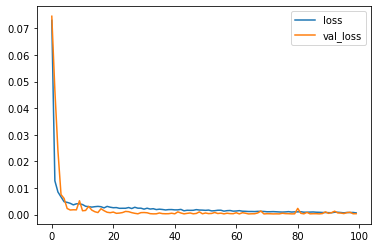

In [37]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [38]:
Y_predict = model.predict(X_test)
Y_predict = Y_Scale.inverse_transform(np.array(Y_predict).reshape(len(Y_predict), 1))
Y_predict

array([[ 78.99297 ],
       [ 77.61796 ],
       [ 75.66352 ],
       [ 77.857216],
       [ 79.185745],
       [ 79.33387 ],
       [ 78.92938 ],
       [ 78.0239  ],
       [ 79.10755 ],
       [ 79.59157 ],
       [ 79.82068 ],
       [ 78.700455],
       [ 78.02813 ],
       [ 78.22336 ],
       [ 76.99328 ],
       [ 75.96119 ],
       [ 72.28174 ],
       [ 72.68557 ],
       [ 71.84841 ],
       [ 68.93718 ],
       [ 65.61622 ],
       [ 70.9379  ],
       [ 72.606895],
       [ 73.40914 ],
       [ 72.810356],
       [ 70.278175],
       [ 66.41209 ],
       [ 68.61316 ],
       [ 68.30921 ],
       [ 63.54674 ],
       [ 65.433235],
       [ 61.412678],
       [ 61.251793],
       [ 60.19214 ],
       [ 61.375507],
       [ 59.310097],
       [ 54.877567],
       [ 59.580925],
       [ 62.12518 ],
       [ 62.36724 ],
       [ 62.45709 ],
       [ 62.678272],
       [ 63.703926],
       [ 60.796818],
       [ 59.952442],
       [ 60.35753 ],
       [ 63.31391 ],
       [ 65.9

In [39]:
train_loss = model.evaluate(X_train,Y_train, batch_size = 1)
test_loss = model.evaluate(X_test,Y_test, batch_size = 1)
print("Training loss and Testing loss are",np.around(train_loss, 5), "and", np.around(test_loss, 5),"respectively")

317/317 [==============================] - 2s 6ms/step - loss: 0.0116
Training loss and Testing loss are 0.00017 and 0.01162 respectively


In [40]:
rmse = np.sqrt(np.mean(np.power((Y_test - Y_predict), 2)))
print("Root Mean Square Error = ",round(rmse, 5))

Root Mean Square Error =  101.78435


In [41]:
rmse1 = metrics.mean_squared_error(Y_test, Y_predict)
print("Root Mean Square Error (sklearn.metrics) = ",round(np.sqrt(rmse1), 5))

Root Mean Square Error (sklearn.metrics) =  101.78435


In [42]:
X_test = X_Scale.inverse_transform(np.array(X_test).reshape(len(X_test), len(columns)))
Y_train = Y_Scale.inverse_transform(np.array(Y_train).reshape(len(Y_train), 1))
Y_test = Y_Scale.inverse_transform(np.array(Y_test).reshape(len(Y_test), 1))

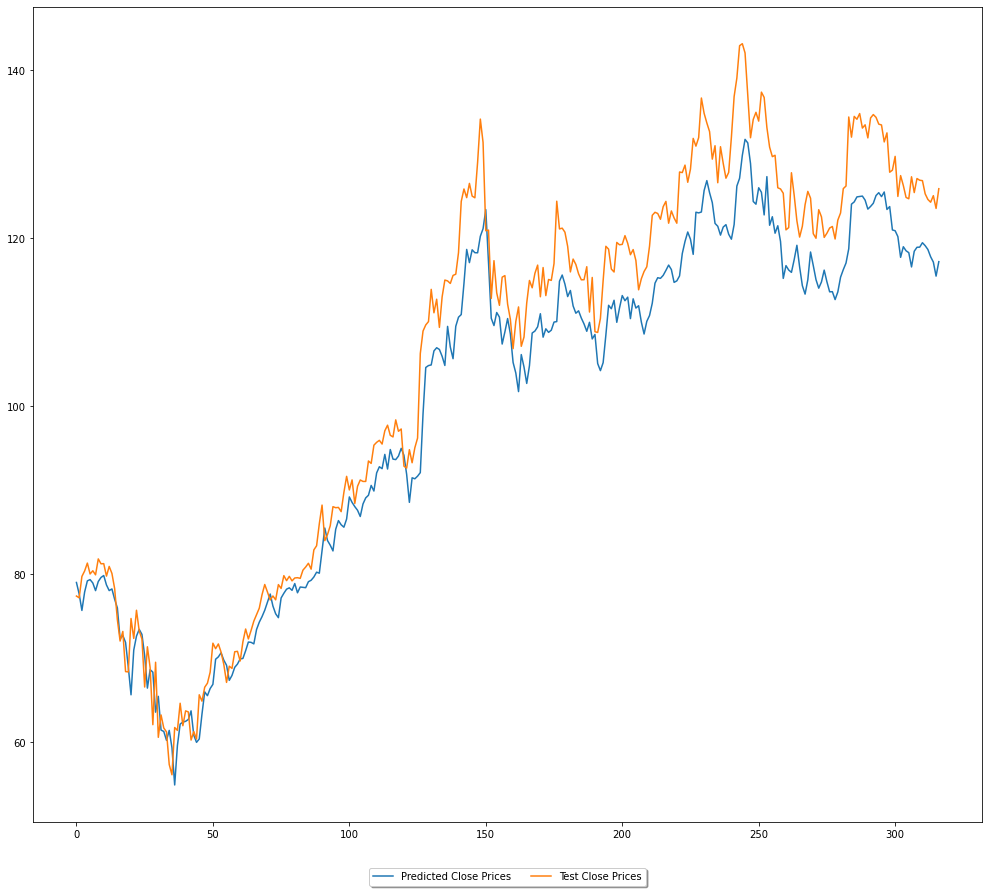

In [43]:
plt.figure(figsize = (17,15))
plt.plot(Y_predict, label = "Predicted Close Prices")
plt.plot([row[0] for row in Y_test], label = "Test Close Prices")
plt.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.05), fancybox = True, shadow = True, ncol = 2)
plt.show()

In [44]:
json_model = model.to_json()
with open('Stock_Price_model.json','w') as json_file:
  json_file.write(json_model)

In [45]:
model.save('Stock_Price_Prediction.h5')